In [2]:
# Import necessary dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
import seaborn as sns
import pickle

#### Read and merge datasets

In [2]:
calendar = pd.read_csv('../data/calendar.csv')
inventory = pd.read_csv('../data/inventory.csv')
sales_train = pd.read_csv('../data/sales_train.csv')
sales_test = pd.read_csv('../data/sales_test.csv')
test_weights = pd.read_csv('../data/test_weights.csv')

In [3]:
# Ensure that `unique_id` dtypes are all `str`
calendar['date'] = calendar.loc[:, 'date'].astype('str')
sales_train['date'] = sales_train.loc[:, 'date'].astype('str')
sales_test['date'] = sales_test.loc[:, 'date'].astype('str')

inventory['unique_id'] = inventory.loc[:, 'unique_id'].astype('str')
sales_train['unique_id'] = sales_train.loc[:, 'unique_id'].astype('str')
sales_test['unique_id'] = sales_test.loc[:, 'unique_id'].astype('str')
test_weights['unique_id'] = test_weights.loc[:, 'unique_id'].astype('str')

In [4]:
inventory.head()

,unique_id,product_unique_id,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,warehouse
0,5255,2583,Pastry_196,Bakery,Bakery_L2_14,Bakery_L3_26,Bakery_L4_1,Prague_3
1,4948,2426,Herb_19,Fruit and vegetable,Fruit and vegetable_L2_30,Fruit and vegetable_L3_86,Fruit and vegetable_L4_1,Prague_3
2,2146,1079,Beet_2,Fruit and vegetable,Fruit and vegetable_L2_3,Fruit and vegetable_L3_65,Fruit and vegetable_L4_34,Prague_1
3,501,260,Chicken_13,Meat and fish,Meat and fish_L2_13,Meat and fish_L3_27,Meat and fish_L4_5,Prague_1
4,4461,2197,Chicory_1,Fruit and vegetable,Fruit and vegetable_L2_17,Fruit and vegetable_L3_33,Fruit and vegetable_L4_1,Frankfurt_1


In [5]:
calendar.head()

,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,warehouse
0,2022-03-16,NaN,0,0,0,0,Frankfurt_1
1,2020-03-22,NaN,0,0,0,0,Frankfurt_1
2,2018-02-07,NaN,0,0,0,0,Frankfurt_1
3,2018-08-10,NaN,0,0,0,0,Frankfurt_1
4,2017-10-26,NaN,0,0,0,0,Prague_2


In [6]:
sales_train.head()

,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount
0,4845,2024-03-10,Budapest_1,6436.0,16.34,646.26,1.00,0.00000,0.0,0.0,0.0,0.15312,0.0,0.0
1,4845,2021-05-25,Budapest_1,4663.0,12.63,455.96,1.00,0.00000,0.0,0.0,0.0,0.15025,0.0,0.0
2,4845,2021-12-20,Budapest_1,6507.0,34.55,455.96,1.00,0.00000,0.0,0.0,0.0,0.15025,0.0,0.0
3,4845,2023-04-29,Budapest_1,5463.0,34.52,646.26,0.96,0.20024,0.0,0.0,0.0,0.15312,0.0,0.0
4,4845,2022-04-01,Budapest_1,5997.0,35.92,486.41,1.00,0.00000,0.0,0.0,0.0,0.15649,0.0,0.0


In [7]:
inventory.columns.values

array(['unique_id', 'product_unique_id', 'name', 'L1_category_name_en',
       'L2_category_name_en', 'L3_category_name_en',
       'L4_category_name_en', 'warehouse'], dtype=object)

In [8]:
# Merge `sales_train` and `inventory` on `unique_id`
sales_train = pd.merge(
    left=sales_train,
    right=inventory.loc[:, ['unique_id', 'L1_category_name_en', 'L2_category_name_en', 'L3_category_name_en', 'L4_category_name_en']],
    on='unique_id'
)

sales_test = pd.merge(
    left=sales_test,
    right=inventory.loc[:, ['unique_id', 'L1_category_name_en', 'L2_category_name_en', 'L3_category_name_en', 'L4_category_name_en']],
    on='unique_id'
)

print(f'Shape of Train dataset: {sales_train.shape}')
print(f'Shape of Test dataset: {sales_test.shape}')

sales_train.head()

Shape of Train dataset: (4007419, 18)
Shape of Test dataset: (47021, 16)


,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en
0,4845,2024-03-10,Budapest_1,6436.0,16.34,646.26,1.00,0.00000,0.0,0.0,0.0,0.15312,0.0,0.0,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1
1,4845,2021-05-25,Budapest_1,4663.0,12.63,455.96,1.00,0.00000,0.0,0.0,0.0,0.15025,0.0,0.0,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1
2,4845,2021-12-20,Budapest_1,6507.0,34.55,455.96,1.00,0.00000,0.0,0.0,0.0,0.15025,0.0,0.0,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1
3,4845,2023-04-29,Budapest_1,5463.0,34.52,646.26,0.96,0.20024,0.0,0.0,0.0,0.15312,0.0,0.0,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1
4,4845,2022-04-01,Budapest_1,5997.0,35.92,486.41,1.00,0.00000,0.0,0.0,0.0,0.15649,0.0,0.0,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1


<Axes: >

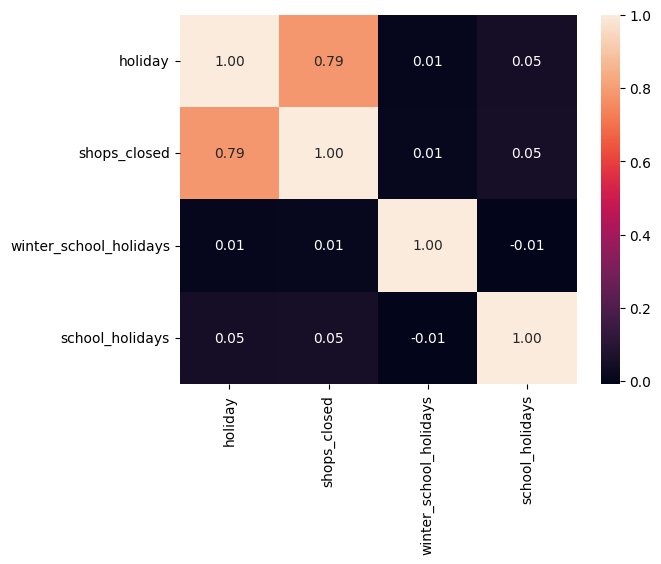

In [9]:
# Check the `calendar` correlation across all numeric values
calendar_corr = calendar.select_dtypes(include=['number']).corr()
sns.heatmap(data=calendar_corr, annot=True, fmt='.2f')

As you can see from the plot above, `holiday` and `shops_closed` have high correlation. That is why we can exclude `shops_closed` from our final dataset as `holiday` seems more relevant in general.

In [10]:
# Grop `calendar` by `date` and calculate max values for each date feature
calendar = calendar.groupby(by=['date']).aggregate(
    func={
        'holiday': 'max',
        'winter_school_holidays': 'max',
        'school_holidays': 'max'
    }
).reset_index()
calendar.head()

,date,holiday,winter_school_holidays,school_holidays
0,2016-01-01,1,0,0
1,2016-01-02,0,0,0
2,2016-01-03,0,0,0
3,2016-01-04,0,0,0
4,2016-01-05,0,0,0


In [11]:
# Merge `sales_train` and `calendar` on `unique_id`
sales_train = pd.merge(
    left=sales_train,
    right=calendar.loc[:, ['date', 'holiday', 'winter_school_holidays', 'school_holidays']],
    on='date'
)

sales_train.head()

,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,...,type_4_discount,type_5_discount,type_6_discount,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,holiday,winter_school_holidays,school_holidays
0,4845,2024-03-10,Budapest_1,6436.0,16.34,646.26,1.00,0.00000,0.0,0.0,...,0.15312,0.0,0.0,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,0,0,0
1,4845,2021-05-25,Budapest_1,4663.0,12.63,455.96,1.00,0.00000,0.0,0.0,...,0.15025,0.0,0.0,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,0,0,0
2,4845,2021-12-20,Budapest_1,6507.0,34.55,455.96,1.00,0.00000,0.0,0.0,...,0.15025,0.0,0.0,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,0,0,0
3,4845,2023-04-29,Budapest_1,5463.0,34.52,646.26,0.96,0.20024,0.0,0.0,...,0.15312,0.0,0.0,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,0,0,0
4,4845,2022-04-01,Budapest_1,5997.0,35.92,486.41,1.00,0.00000,0.0,0.0,...,0.15649,0.0,0.0,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,0,0,0


In [12]:
sales_test = pd.merge(
    left=sales_test,
    right=calendar.loc[:, ['date', 'holiday', 'winter_school_holidays', 'school_holidays']],
    on='date'
)

sales_test.head()

,unique_id,date,warehouse,total_orders,sell_price_main,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,holiday,winter_school_holidays,school_holidays
0,1226,2024-06-03,Brno_1,8679.0,13.13,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,Bakery,Bakery_L2_14,Bakery_L3_37,Bakery_L4_1,0,0,0
1,1226,2024-06-11,Brno_1,8795.0,13.13,0.15873,0.0,0.0,0.0,0.0,0.0,0.0,Bakery,Bakery_L2_14,Bakery_L3_37,Bakery_L4_1,0,0,0
2,1226,2024-06-13,Brno_1,10009.0,13.13,0.15873,0.0,0.0,0.0,0.0,0.0,0.0,Bakery,Bakery_L2_14,Bakery_L3_37,Bakery_L4_1,0,0,0
3,1226,2024-06-15,Brno_1,8482.0,13.13,0.15873,0.0,0.0,0.0,0.0,0.0,0.0,Bakery,Bakery_L2_14,Bakery_L3_37,Bakery_L4_1,0,0,0
4,1226,2024-06-09,Brno_1,8195.0,13.13,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,Bakery,Bakery_L2_14,Bakery_L3_37,Bakery_L4_1,0,0,0


In [13]:
# Merge weights with the datasets
sales_train = pd.merge(
    left=sales_train,
    right=test_weights,
    on='unique_id'
)

sales_train.head()

,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,...,type_5_discount,type_6_discount,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,holiday,winter_school_holidays,school_holidays,weight
0,4845,2024-03-10,Budapest_1,6436.0,16.34,646.26,1.00,0.00000,0.0,0.0,...,0.0,0.0,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,0,0,0,1.925596
1,4845,2021-05-25,Budapest_1,4663.0,12.63,455.96,1.00,0.00000,0.0,0.0,...,0.0,0.0,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,0,0,0,1.925596
2,4845,2021-12-20,Budapest_1,6507.0,34.55,455.96,1.00,0.00000,0.0,0.0,...,0.0,0.0,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,0,0,0,1.925596
3,4845,2023-04-29,Budapest_1,5463.0,34.52,646.26,0.96,0.20024,0.0,0.0,...,0.0,0.0,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,0,0,0,1.925596
4,4845,2022-04-01,Budapest_1,5997.0,35.92,486.41,1.00,0.00000,0.0,0.0,...,0.0,0.0,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,0,0,0,1.925596


In [14]:
sales_test = pd.merge(
    left=sales_test,
    right=test_weights,
    on='unique_id'
)

sales_test.head()

,unique_id,date,warehouse,total_orders,sell_price_main,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,holiday,winter_school_holidays,school_holidays,weight
0,1226,2024-06-03,Brno_1,8679.0,13.13,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,Bakery,Bakery_L2_14,Bakery_L3_37,Bakery_L4_1,0,0,0,0.811295
1,1226,2024-06-11,Brno_1,8795.0,13.13,0.15873,0.0,0.0,0.0,0.0,0.0,0.0,Bakery,Bakery_L2_14,Bakery_L3_37,Bakery_L4_1,0,0,0,0.811295
2,1226,2024-06-13,Brno_1,10009.0,13.13,0.15873,0.0,0.0,0.0,0.0,0.0,0.0,Bakery,Bakery_L2_14,Bakery_L3_37,Bakery_L4_1,0,0,0,0.811295
3,1226,2024-06-15,Brno_1,8482.0,13.13,0.15873,0.0,0.0,0.0,0.0,0.0,0.0,Bakery,Bakery_L2_14,Bakery_L3_37,Bakery_L4_1,0,0,0,0.811295
4,1226,2024-06-09,Brno_1,8195.0,13.13,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,Bakery,Bakery_L2_14,Bakery_L3_37,Bakery_L4_1,0,0,0,0.811295


#### Preprocess and encode features

<Axes: >

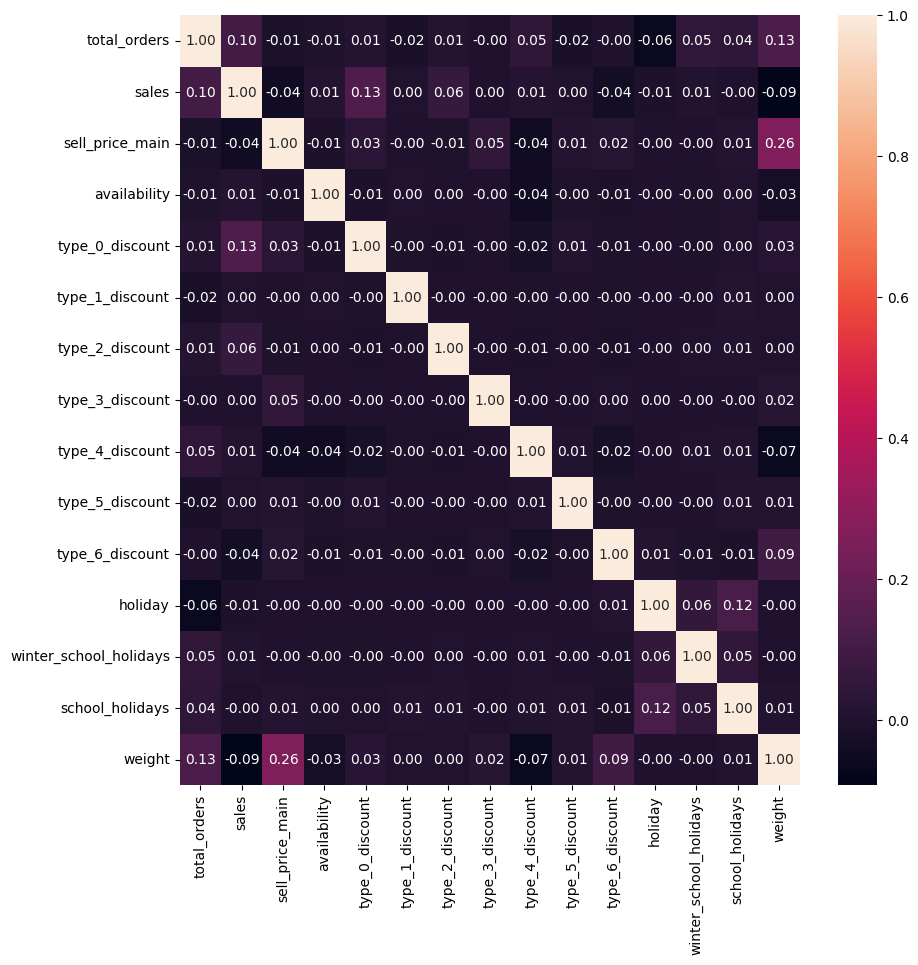

In [15]:
# Check overall correlation
numeric_correlation_train = sales_train.select_dtypes(include=['number']).corr()

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(numeric_correlation_train, annot=True, fmt='.2f')

In [16]:
# Check for missing values
sales_train.isna().sum()

unique_id                  0
date                       0
warehouse                  0
total_orders              52
sales                     52
sell_price_main            0
availability               0
type_0_discount            0
type_1_discount            0
type_2_discount            0
type_3_discount            0
type_4_discount            0
type_5_discount            0
type_6_discount            0
L1_category_name_en        0
L2_category_name_en        0
L3_category_name_en        0
L4_category_name_en        0
holiday                    0
winter_school_holidays     0
school_holidays            0
weight                     0
dtype: int64

In [17]:
sales_test.isna().sum()

unique_id                 0
date                      0
warehouse                 0
total_orders              0
sell_price_main           0
type_0_discount           0
type_1_discount           0
type_2_discount           0
type_3_discount           0
type_4_discount           0
type_5_discount           0
type_6_discount           0
L1_category_name_en       0
L2_category_name_en       0
L3_category_name_en       0
L4_category_name_en       0
holiday                   0
winter_school_holidays    0
school_holidays           0
weight                    0
dtype: int64

In [18]:
# Drop missing values from `sales_train`
sales_train = sales_train.dropna()
sales_train.isna().sum()

unique_id                 0
date                      0
warehouse                 0
total_orders              0
sales                     0
sell_price_main           0
availability              0
type_0_discount           0
type_1_discount           0
type_2_discount           0
type_3_discount           0
type_4_discount           0
type_5_discount           0
type_6_discount           0
L1_category_name_en       0
L2_category_name_en       0
L3_category_name_en       0
L4_category_name_en       0
holiday                   0
winter_school_holidays    0
school_holidays           0
weight                    0
dtype: int64

In [19]:
sales_train.head()

,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,...,type_5_discount,type_6_discount,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,holiday,winter_school_holidays,school_holidays,weight
0,4845,2024-03-10,Budapest_1,6436.0,16.34,646.26,1.00,0.00000,0.0,0.0,...,0.0,0.0,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,0,0,0,1.925596
1,4845,2021-05-25,Budapest_1,4663.0,12.63,455.96,1.00,0.00000,0.0,0.0,...,0.0,0.0,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,0,0,0,1.925596
2,4845,2021-12-20,Budapest_1,6507.0,34.55,455.96,1.00,0.00000,0.0,0.0,...,0.0,0.0,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,0,0,0,1.925596
3,4845,2023-04-29,Budapest_1,5463.0,34.52,646.26,0.96,0.20024,0.0,0.0,...,0.0,0.0,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,0,0,0,1.925596
4,4845,2022-04-01,Budapest_1,5997.0,35.92,486.41,1.00,0.00000,0.0,0.0,...,0.0,0.0,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,0,0,0,1.925596


In [20]:
# Check the differences between prices in different warehouses
sales_train.groupby(by=['warehouse'])['sell_price_main'].mean()

warehouse
Brno_1          67.873869
Budapest_1     918.184147
Frankfurt_1      2.977871
Munich_1         3.002305
Prague_1        65.941507
Prague_2        65.624530
Prague_3        67.141527
Name: sell_price_main, dtype: float64

In [21]:
sales_test.groupby(by=['warehouse'])['sell_price_main'].mean()

warehouse
Brno_1           74.363671
Budapest_1     1098.636423
Frankfurt_1       3.208569
Munich_1          3.367896
Prague_1         73.106011
Prague_2         72.141337
Prague_3         75.208574
Name: sell_price_main, dtype: float64

In [22]:
# Create 3 new features: `month`, `day_of_week`, `is_weekend`
sales_train['month'] = pd.to_datetime(sales_train.loc[:, 'date']).dt.month
sales_train['day_of_week'] = pd.to_datetime(sales_train.loc[:, 'date']).dt.dayofweek
sales_train['is_weekend'] = sales_train.loc[:, 'day_of_week'].apply(func=lambda x: 1 if x >= 5 else 0)

sales_test['month'] = pd.to_datetime(sales_test.loc[:, 'date']).dt.month
sales_test['day_of_week'] = pd.to_datetime(sales_test.loc[:, 'date']).dt.dayofweek
sales_test['is_weekend'] = sales_test.loc[:, 'day_of_week'].apply(func=lambda x: 1 if x >= 5 else 0)

sales_train.head()

,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,...,L2_category_name_en,L3_category_name_en,L4_category_name_en,holiday,winter_school_holidays,school_holidays,weight,month,day_of_week,is_weekend
0,4845,2024-03-10,Budapest_1,6436.0,16.34,646.26,1.00,0.00000,0.0,0.0,...,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,0,0,0,1.925596,3,6,1
1,4845,2021-05-25,Budapest_1,4663.0,12.63,455.96,1.00,0.00000,0.0,0.0,...,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,0,0,0,1.925596,5,1,0
2,4845,2021-12-20,Budapest_1,6507.0,34.55,455.96,1.00,0.00000,0.0,0.0,...,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,0,0,0,1.925596,12,0,0
3,4845,2023-04-29,Budapest_1,5463.0,34.52,646.26,0.96,0.20024,0.0,0.0,...,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,0,0,0,1.925596,4,5,1
4,4845,2022-04-01,Budapest_1,5997.0,35.92,486.41,1.00,0.00000,0.0,0.0,...,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,0,0,0,1.925596,4,4,0


In [23]:
# Check whether we have any duplicates in our data
print(sales_train.duplicated().sum())
print(sales_test.duplicated().sum())

0
0


In [24]:
# Use ordinal encoding for `warehouse` feature
warehouse_ordinal_encoder = OrdinalEncoder()

sales_train['warehouse'] = warehouse_ordinal_encoder.fit_transform(sales_train.loc[:, ['warehouse']])

sales_train.head()

,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,...,L2_category_name_en,L3_category_name_en,L4_category_name_en,holiday,winter_school_holidays,school_holidays,weight,month,day_of_week,is_weekend
0,4845,2024-03-10,1.0,6436.0,16.34,646.26,1.00,0.00000,0.0,0.0,...,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,0,0,0,1.925596,3,6,1
1,4845,2021-05-25,1.0,4663.0,12.63,455.96,1.00,0.00000,0.0,0.0,...,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,0,0,0,1.925596,5,1,0
2,4845,2021-12-20,1.0,6507.0,34.55,455.96,1.00,0.00000,0.0,0.0,...,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,0,0,0,1.925596,12,0,0
3,4845,2023-04-29,1.0,5463.0,34.52,646.26,0.96,0.20024,0.0,0.0,...,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,0,0,0,1.925596,4,5,1
4,4845,2022-04-01,1.0,5997.0,35.92,486.41,1.00,0.00000,0.0,0.0,...,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,0,0,0,1.925596,4,4,0


In [25]:
sales_test['warehouse'] = warehouse_ordinal_encoder.transform(sales_test.loc[:, ['warehouse']])
sales_test.head()

,unique_id,date,warehouse,total_orders,sell_price_main,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,...,L2_category_name_en,L3_category_name_en,L4_category_name_en,holiday,winter_school_holidays,school_holidays,weight,month,day_of_week,is_weekend
0,1226,2024-06-03,0.0,8679.0,13.13,0.00000,0.0,0.0,0.0,0.0,...,Bakery_L2_14,Bakery_L3_37,Bakery_L4_1,0,0,0,0.811295,6,0,0
1,1226,2024-06-11,0.0,8795.0,13.13,0.15873,0.0,0.0,0.0,0.0,...,Bakery_L2_14,Bakery_L3_37,Bakery_L4_1,0,0,0,0.811295,6,1,0
2,1226,2024-06-13,0.0,10009.0,13.13,0.15873,0.0,0.0,0.0,0.0,...,Bakery_L2_14,Bakery_L3_37,Bakery_L4_1,0,0,0,0.811295,6,3,0
3,1226,2024-06-15,0.0,8482.0,13.13,0.15873,0.0,0.0,0.0,0.0,...,Bakery_L2_14,Bakery_L3_37,Bakery_L4_1,0,0,0,0.811295,6,5,1
4,1226,2024-06-09,0.0,8195.0,13.13,0.00000,0.0,0.0,0.0,0.0,...,Bakery_L2_14,Bakery_L3_37,Bakery_L4_1,0,0,0,0.811295,6,6,1


In [26]:
sales_train.dtypes

unique_id                  object
date                       object
warehouse                 float64
total_orders              float64
sales                     float64
sell_price_main           float64
availability              float64
type_0_discount           float64
type_1_discount           float64
type_2_discount           float64
type_3_discount           float64
type_4_discount           float64
type_5_discount           float64
type_6_discount           float64
L1_category_name_en        object
L2_category_name_en        object
L3_category_name_en        object
L4_category_name_en        object
holiday                     int64
winter_school_holidays      int64
school_holidays             int64
weight                    float64
month                       int32
day_of_week                 int32
is_weekend                  int64
dtype: object

In [27]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')

one_hot_cols = [
    'L1_category_name_en',
    'L2_category_name_en',
    'L3_category_name_en',
    'L4_category_name_en'
]

#sales_train = pd.concat(objs=[sales_train, one_hot_encoder.fit_transform(sales_train.loc[:, one_hot_cols])], axis=1)
one_hot_train = pd.concat([sales_train.loc[:, 'date'], one_hot_encoder.fit_transform(sales_train.loc[:, one_hot_cols])], axis=1)
#sales_test = pd.concat(objs=[sales_test, one_hot_encoder.transform(sales_test.loc[:, one_hot_cols])], axis=1)
one_hot_test = pd.concat([sales_test.loc[:, 'date'], one_hot_encoder.transform(sales_test.loc[:, one_hot_cols])], axis=1)

#sales_train.head()
one_hot_train.head()

,date,L1_category_name_en_Bakery,L1_category_name_en_Fruit and vegetable,L1_category_name_en_Meat and fish,L2_category_name_en_Bakery_L2_10,L2_category_name_en_Bakery_L2_14,L2_category_name_en_Bakery_L2_18,L2_category_name_en_Bakery_L2_21,L2_category_name_en_Bakery_L2_22,L2_category_name_en_Bakery_L2_24,...,L4_category_name_en_Meat and fish_L4_48,L4_category_name_en_Meat and fish_L4_5,L4_category_name_en_Meat and fish_L4_50,L4_category_name_en_Meat and fish_L4_51,L4_category_name_en_Meat and fish_L4_54,L4_category_name_en_Meat and fish_L4_59,L4_category_name_en_Meat and fish_L4_6,L4_category_name_en_Meat and fish_L4_62,L4_category_name_en_Meat and fish_L4_63,L4_category_name_en_Meat and fish_L4_7
0,2024-03-10,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-05-25,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-12-20,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023-04-29,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-04-01,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
sales_train = sales_train.drop(labels=one_hot_cols, axis=1)
sales_test = sales_test.drop(labels=one_hot_cols, axis=1)

sales_train.shape

(4007367, 21)

In [29]:
missing_cols = list(set(sales_train.columns.values) - set(sales_test.columns.values))
missing_cols

['availability', 'sales']

In [39]:
# Select Out of Time (OOT) dataset
oot_flag = '2024-05-01'
X_oot = sales_train.loc[sales_train.loc[:, 'date'] >= oot_flag]
one_hot_train_oot = one_hot_train.loc[one_hot_train.loc[:, 'date'] >= oot_flag]
X_oot

,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,...,type_4_discount,type_5_discount,type_6_discount,holiday,winter_school_holidays,school_holidays,weight,month,day_of_week,is_weekend
16,4845,2024-05-11,1.0,6469.0,20.61,646.26,1.00,0.00000,0.0,0.0,...,0.15312,0.00000,0.0,0,0,0,1.925596,5,5,1
61,4845,2024-05-18,1.0,5820.0,23.84,646.26,1.00,0.00000,0.0,0.0,...,0.15312,0.00000,0.0,0,0,1,1.925596,5,5,1
62,4845,2024-05-03,1.0,7237.0,43.96,646.26,1.00,0.00000,0.0,0.0,...,0.15312,0.00000,0.0,0,0,0,1.925596,5,4,0
108,4845,2024-05-30,1.0,6763.0,27.25,646.26,1.00,0.00000,0.0,0.0,...,0.15312,0.00000,0.0,1,0,1,1.925596,5,3,0
153,4845,2024-05-07,1.0,6669.0,11.65,646.26,1.00,0.00000,0.0,0.0,...,0.15312,0.00000,0.0,0,0,0,1.925596,5,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4007302,1836,2024-05-26,2.0,1181.0,79.85,0.88,1.00,0.00000,0.0,0.0,...,0.00000,0.00000,0.0,0,0,1,1.314378,5,6,1
4007303,1836,2024-05-22,2.0,1651.0,151.44,0.88,0.84,0.00000,0.0,0.0,...,0.00000,0.00000,0.0,0,0,1,1.314378,5,2,0
4007304,1836,2024-05-17,2.0,2143.0,154.25,0.88,0.61,0.00000,0.0,0.0,...,0.00000,0.00000,0.0,0,0,0,1.314378,5,4,0
4007305,1836,2024-05-28,2.0,1783.0,151.82,0.88,1.00,0.00000,0.0,0.0,...,0.00000,0.00000,0.0,0,0,1,1.314378,5,1,0


In [41]:
print(f"OOT Period: {X_oot.loc[:, 'date'].min()} - {X_oot.loc[:, 'date'].max()}")

OOT Period: 2024-05-01 - 2024-06-02


In [42]:
# The rest of `train_sales` will go to Train/Val datasets
X_train_val = sales_train.loc[sales_train.loc[:, 'date'] < oot_flag]
one_hot_train_val = one_hot_train.loc[one_hot_train.loc[:, 'date'] < oot_flag]
print(f"Train/Val Period: {X_train_val.loc[:, 'date'].min()} - {X_train_val.loc[:, 'date'].max()}")
del one_hot_train

Train/Val Period: 2020-08-01 - 2024-04-30


In [ ]:
X_train, X_val, X_train_one_hot, X_val_one_hot = train_test_split(X_train_val, one_hot_train_val, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_train_one_hot.shape)

In [44]:
del one_hot_train_val

In [45]:
X_train = pd.concat([X_train, X_train_one_hot.drop(labels=['date'], axis=1)], axis=1)
X_val = pd.concat([X_val, X_val_one_hot.drop(labels=['date'], axis=1)], axis=1)
print(X_train.shape)
print(X_val.shape)
del X_train_one_hot, X_val_one_hot

(3116313, 315)
(779079, 315)


In [46]:
features = [col for col in X_train.columns if col not in ['date', 'availability', 'unique_id','sales']]
len(features)

311

In [50]:
X_oot = pd.concat([X_oot, one_hot_train_oot.drop(labels=['date'], axis=1)], axis=1)
del one_hot_train_oot
X_oot.shape

(111975, 315)

In [51]:
temp_datasets = {
    'X_train': X_train,
    'X_val': X_val,
    'X_oot': X_oot,
    'features': features,
    #'sales_test': sales_test
}

In [52]:
with open('../data/main_datasets.pkl', 'wb+') as f:
    pickle.dump(temp_datasets, f)

In [53]:
del X_train, X_val, X_oot, temp_datasets

In [56]:
X_test = pd.concat([sales_test, one_hot_test.drop(labels=['date'], axis=1)], axis=1)
X_test.shape

(47021, 313)

In [57]:
test_dataset = {
    'X_test': X_test
}

In [58]:
with open('../data/test_dataset.pkl', 'wb+') as f:
    pickle.dump(test_dataset, f)

#### Data Scaling

In [3]:
temp_datasets = {}

with open('../data/main_datasets.pkl', 'rb+') as f:
    temp_datasets = pickle.load(f)

In [4]:
X_train, X_val, X_oot, features = temp_datasets['X_train'], temp_datasets['X_val'], temp_datasets['X_oot'], temp_datasets['features']
del temp_datasets

In [5]:
y_train, y_val, y_oot = X_train.loc[:, 'sales'].copy(), X_val.loc[:, 'sales'].copy(), X_oot.loc[:, 'sales'].copy()
train_weights, val_weights, oot_weights = X_train.loc[:, 'weight'].copy(), X_val.loc[:, 'weight'].copy(), X_oot.loc[:, 'weight'].copy()

In [7]:
standard_scaler = StandardScaler().fit(X_train.loc[:, features])
X_train = standard_scaler.transform(X_train.loc[:, features])
X_val = standard_scaler.transform(X_val.loc[:, features])
X_oot = standard_scaler.transform(X_oot.loc[:, features])

In [11]:
main_datasets_scaled = {
    'X_train': X_train,
    'X_val': X_val,
    'X_oot': X_oot
}

In [12]:
with open('../data/main_datasets_scaled.pkl', 'wb+') as f:
    pickle.dump(main_datasets_scaled, f)

In [32]:
features[:10]

['warehouse',
 'total_orders',
 'sell_price_main',
 'type_0_discount',
 'type_1_discount',
 'type_2_discount',
 'type_3_discount',
 'type_4_discount',
 'type_5_discount',
 'type_6_discount']

In [6]:
del X_train, X_val, X_oot

In [14]:
# Do the same with test_dataset
with open('../data/test_dataset.pkl', 'rb+') as f:
    X_test = pickle.load(f)['X_test']

In [ ]:
X_test = standard_scaler.transform(X_test.loc[:, features])

In [17]:
# Save to the neww  `.pkl` file
with open('../data/test_dataset_scaled.pkl', 'wb+') as f:
    pickle.dump(
        {
            'X_test': X_test
        },
        f
    )

In [19]:
del X_test

#### Model Set Up

In [7]:
temp_datasets = {}

with open('../data/main_datasets_scaled.pkl', 'rb+') as f:
    temp_datasets = pickle.load(f)

In [8]:
X_train, X_val, X_oot = temp_datasets['X_train'], temp_datasets['X_val'], temp_datasets['X_oot']
del temp_datasets

In [9]:
xgb_regressor = XGBRegressor(random_state=42)
xgb_regressor

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [10]:
# Helper function to calculate WMAE
def WMAE(y_true: pd.Series | np.ndarray, y_pred: pd.Series | np.ndarray, weights: pd.Series | np.ndarray) -> float:
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

In [11]:
# Fit the base `XGBRegressor` model
xgb_regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [14]:
# Helper function to display the results
def generate_report(datasets: list[tuple[str, np.ndarray | pd.DataFrame, np.ndarray | pd.Series, np.ndarray | pd.Series]], model: any) -> None:
    for dataset_name, dataset, target, weights in datasets:
        preds = model.predict(dataset)
        print(f"{dataset_name}:\nMAE: {mean_absolute_error(target, preds)}\nWMAE: {WMAE(target, preds, weights)}\nR^2: {r2_score(target, preds)}\n----------")
        del preds

In [16]:
# Check the performance on different datasets
generate_report(
    datasets=[
        ('Train', X_train, y_train, train_weights),
        ('Val', X_val, y_val, val_weights),
        ('OOT', X_oot, y_oot, oot_weights)
    ],
    model=xgb_regressor
)

Train:
MAE: 49.463847751229814
WMAE: 38.71818069341753
R^2: 0.9152294440348998
----------
Val:
MAE: 49.51225594133829
WMAE: 38.69182872973208
R^2: 0.9126127038321449
----------
OOT:
MAE: 57.71490229628424
WMAE: 44.635979519536924
R^2: 0.9023785196604999
----------


#### Create file submission

In [12]:
del X_train, X_val, X_oot

In [13]:
with open('../data/test_dataset_scaled.pkl', 'rb+') as f:
    X_test = pickle.load(f)['X_test']
X_test.shape

(47021, 311)

In [14]:
with open('../data/test_dataset.pkl', 'rb+') as f:
    X_test_full = pickle.load(f)['X_test']
X_test_full.shape

(47021, 313)

In [15]:
X_test_full.loc[:, 'unique_id'] + '_' + X_test_full.loc[:, 'date']

0        1226_2024-06-03
1        1226_2024-06-11
2        1226_2024-06-13
3        1226_2024-06-15
4        1226_2024-06-09
              ...       
47016    4572_2024-06-03
47017    3735_2024-06-04
47018    3735_2024-06-03
47019    2129_2024-06-03
47020    3030_2024-06-03
Length: 47021, dtype: object

In [16]:
submission = pd.DataFrame(
    data={
        'id': X_test_full.loc[:, 'unique_id'] + '_' + X_test_full.loc[:, 'date'],
        'sales_hat': xgb_regressor.predict(X_test)
    }
)
# Remove negative values
submission['sales_hat'] = submission.loc[:, 'sales_hat'].apply(func=lambda x: x if x >= 0.0 else 0.0)

submission.head()

,id,sales_hat
0,1226_2024-06-03,46.195980
1,1226_2024-06-11,341.808533
2,1226_2024-06-13,355.862000
3,1226_2024-06-15,241.480774
4,1226_2024-06-09,46.891796


In [17]:
# Create a `.csv` with submission
submission.to_csv('../submissions/submission_xgb_v1.csv', index=False)

#### `TODO` Model fine-tuning